In [23]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

In [24]:
df = web.DataReader('TEVA', data_source='yahoo', start='2012-01-01', end='2021-03-16')
df.sample(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,65.339996,64.209999,64.389999,65.300003,4705400.0,61.410942
2014-03-04,49.580002,48.709999,49.180000,49.410000,7200500.0,44.575947
2016-12-29,36.259998,35.810001,35.849998,36.080002,3618100.0,34.899441
2018-05-22,21.219999,20.940001,21.190001,21.000000,8729200.0,21.000000
2019-12-06,10.110000,9.850000,9.850000,9.920000,12246900.0,9.920000
2017-06-20,31.559999,30.959999,31.170000,31.370001,4563700.0,31.013393
2018-01-22,21.389999,20.150000,20.170000,21.020000,20759300.0,21.020000
2017-12-28,19.040001,18.809999,18.950001,19.000000,11386900.0,19.000000
2013-04-15,39.139999,38.619999,38.959999,38.669998,4643400.0,33.787666


In [ ]:
plt.figure(figsize=(16,8))
plt.title('Close price history')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close price USD ($)', fontsize=16)
plt.show()

In [36]:
# DF with only close column
data = df.filter(['Close'])
# Convert to numpy array
dataset = data.values
# Number of rows to train on (80%)
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

1836

In [45]:
# Scale data

scaler = MinMaxScaler(feature_range=(0,1))

scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.56105709],
       [0.56789185],
       [0.57184085],
       ...,
       [0.07806805],
       [0.07533414],
       [0.07743014]])

In [46]:
# Create training data

train_data = scaled_data[0:training_data_len, :]

# Split data into x_train and y_train datasets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [47]:
# Convert x and y to numpy
x_train, y_train = np.array(x_train), np.array(y_train)

In [48]:
# Reshape data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1776, 60, 1)

In [49]:
# Build LSTM model

model = Sequential()
# add layer to model
# LSTM layer, 50 neurons
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


In [50]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [51]:
#Train the model

model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
1776/1776 [==============================] - 85s 45ms/step - loss: 0.0056
Epoch 2/5
 784/1776 [============>.................] - ETA: 44s - loss: 7.5501e-04

KeyboardInterrupt: 

In [12]:
# Save the model

model.summary()

model.save('C:/Users/Micha/Documents/Github/Untitled Folder/model.tf')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Test of loading trained model

new_model = keras.models.load_model('C:/Users/Micha/Documents/Github/Untitled Folder/model.tf')

# Check that the state is preserved
new_predictions = new_model.predict(x_test)
np.testing.assert_allclose(predictions, new_predictions, rtol=1e-6, atol=1e-6)

In [14]:
# create the testing dataset

test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [15]:
# Convert the data to  numpy array
x_test = np.array(x_test)

In [16]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [18]:
# Get the models predicted values

predictions= model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


In [19]:
# get the root mean squarred error (RMSE)

rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

5.573155847214561

C:\Users\Micha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


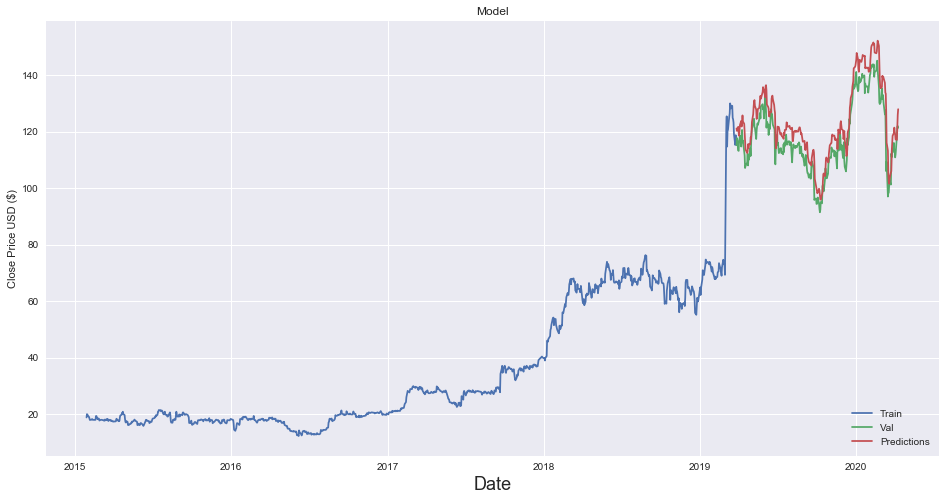

In [21]:
# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'], loc='lower right')
plt.show()

In [ ]:
#Show the valid and predicted prices
valid

In [22]:
# Get the quote
apple_quote = web.DataReader('ASND', data_source='yahoo', start='2012-01-01', end='2020-03-15')

# Create new dataframe
new_df = apple_quote.filter(['Close'])

last_60_days = new_df[-60:].values

last_60_days_scaled = scaler.transform(last_60_days)

X_test = []

X_test.append(last_60_days_scaled)

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price = model.predict(X_test)

pred_price = scaler.inverse_transform(pred_price)

print(pred_price)


[[113.2871]]


In [25]:
apple_quote2 = web.DataReader('ASND', data_source='yahoo', start='2020-03-16', end='2020-03-16')
print(apple_quote2['Close'])

Date
2020-03-16    97.010002
Name: Close, dtype: float64
